**Table of contents**<a id='toc0_'></a>    
- [Proyecto Detección de Fraude en Comercio Electronico](#toc1_)    
    - [Introducción](#toc1_1_1_)    
    - [Objetivos del proyecto](#toc1_1_2_)    
      - [Objetivo general](#toc1_1_2_1_)    
      - [Objetivos específicos](#toc1_1_2_2_)    
      - [KPIs y criterios de éxito (sugeridos)](#toc1_1_2_3_)    
- [Analisis Exploratorio de Datos](#toc2_)    
  - [Correcion de tipo de datos](#toc2_1_)    
  - [Distribucion de Cantidad por Usuario](#toc2_2_)    
    - [Confirmacion de la moda en este caso](#toc2_2_1_)    
  - [Distribucion por Total de transacciones por usuario](#toc2_3_)    
  - [Distribucion del target (is_fraud)](#toc2_4_)    
    - [Conclusiones preliminares del EDA](#toc2_4_1_)    
- [Diagrama de datos outliers](#toc3_)    
    - [Conclusiones preliminares — Hallazgos y outliers](#toc3_1_1_)    
  - [Grafico con hora de mayor flujo de transacciones](#toc3_2_)    
  - [Matriz de correlacion de fraude](#toc3_3_)    
    - [Lecturas clave](#toc3_3_1_)    
- [MACHINE LEARNING MODEL IMPLEMENTATION](#toc4_)    
  - [CREACION DE FEATURES](#toc4_1_)    
  - [Metricas Clave: AUPRC y ROC-AUC](#toc4_2_)    
    - [Conclusión clave](#toc4_2_1_)    
    - [Conclusion Clave](#toc4_2_2_)    
- [Conclusión final del proyecto](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Proyecto Detección de Fraude en Comercio Electronico](#toc0_)


### <a id='toc1_1_1_'></a>[Introducción](#toc0_)

El fraude en transacciones de e‑commerce es un reto continuo para fintechs y comercios: impacta directamente en pérdidas financieras (chargebacks, comisiones, logística), deteriora la experiencia del cliente y exige controles cada vez más estrictos. Este proyecto construye un sistema de detección de fraude supervisado, orientado a operar en tiempo casi real y optimizado por costo de errores (falsos positivos y falsos negativos).

Trabajaremos con un dataset transaccional etiquetado (`is_fraud`) que contiene información a nivel de operación (por ejemplo: monto, país, canal, categoría del comercio, señales de validación como AVS/CVV/3DS, y atributos de comportamiento del usuario como antigüedad y promedios históricos). El objetivo es desarrollar un pipeline reproducible de punta a punta: desde EDA y calidad de datos, ingeniería de características y validación temporal,

El proyecto prioriza métricas adecuadas para clases desbalanceadas (AUPRC, precisión/recobrado en el top‑K) y la minimización del costo esperado con una matriz de costos configurable (p. ej., costo de FN > costo de FP). Además, contempla prácticas de MLOps (tracking de experimentos, versionado de artefactos y monitoreo básico de drift) y consideraciones de privacidad y cumplimiento normativo.

### <a id='toc1_1_2_'></a>[Objetivos del proyecto](#toc0_)

#### <a id='toc1_1_2_1_'></a>[Objetivo general](#toc0_)
Diseñar, entrenar y desplegar un modelo de detección de fraude para e‑commerce que minimice el costo esperado de decisiones (aprobar/rechazar/revisar) bajo desbalance de clases y restricciones de negocio, garantizando reproducibilidad y capacidad de monitoreo.

#### <a id='toc1_1_2_2_'></a>[Objetivos específicos](#toc0_)
- Datos y calidad:
  - Ingerir y versionar el dataset transaccional (`data/transactions.csv`).
  - Realizar EDA y checks de calidad (valores faltantes, outliers, fugas de información, cardinalidades, estacionalidad).
- Validación y particionado:
  - Definir un esquema de validación temporal (train/valid/test por ventana de tiempo) que simule el uso en producción.
- Ingeniería de características:
  - Construir features a nivel transacción y usuario (tendencias, desvíos respecto a promedios del usuario, ratios, señales AVS/CVV/3DS, distancia de envío, etc.), evitando fugas temporales.
- Modelado:
  - Establecer un baseline interpretable (Regresión Logística).
  - Entrenar modelos de árboles graduales (LightGBM/XGBoost) y ajustar hiperparámetros con búsqueda eficiente (Optuna).
  - Calibrar probabilidades (Platt/Isotónica) si es necesario.
- Optimización por costo:
  - Definir y documentar la matriz de costos de negocio (ej. inicial: C_FN = 50, C_FP = 1; ajustable).
  - Seleccionar el umbral óptimo que minimice el costo esperado y reporte trade‑offs (precisión/recobrado).
- Evaluación:
  - Reportar AUPRC, PR@K/Recall@K, curvas PR, costo esperado y matriz de confusión al umbral óptimo.
  - Analizar importancia de variables y explicación local (SHAP) de casos clave.
- Despliegue e inferencia:
  - Empaquetar el modelo y el preprocesamiento en `src/` con artefactos versionados en `models/` y `artifacts/`.
  - Exponer una API de scoring (FastAPI) con validación de esquema y ejemplo de uso.
- MLOps y documentación:
  - Hacer tracking de experimentos (MLflow) y fijar semillas para reproducibilidad.
  - Documentar decisiones, supuestos y resultados en `README` y notebooks (`notebooks/`).
  - Proveer guía de monitoreo inicial (tasa de fraude, drift univariante/PSI) y alertas básicas.

#### <a id='toc1_1_2_3_'></a>[KPIs y criterios de éxito (sugeridos)](#toc0_)
- AUPRC en test superior al baseline (p. ej., objetivo inicial ≥ 0.80, ajustable según datos).
- Reducción del costo esperado por transacción frente a la estrategia sin modelo o reglas simples.
- Recall a una precisión mínima operativa (p. ej., Precisión ≥ 0.5) dentro de los límites de fricción aceptables.
- Tiempo de inferencia compatible con el SLA definido (p. ej., < 100 ms por transacción en lote; requisito ajustable).
- Estabilidad del modelo en validaciones por ventana (variación de métricas acotada).

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from pathlib import Path
from sklearn.compose import ColumnTransformer


# <a id='toc2_'></a>[Analisis Exploratorio de Datos](#toc0_)

In [337]:
# Cargar el dataset transactions.csv utilizando pandas

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Ruta de datos
candidate_paths=[Path("data/raw/transactions.csv"),Path('data/transactions.csv'),Path('transactions.csv')]

data_path= None

for p in candidate_paths:
    if p.exists():
        data_path = p
        break
print(f"Dataset found at: {data_path}")

Dataset found at: data\transactions.csv


In [338]:
# definicion df

data=pd.read_csv(data_path,sep=',')

display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

None

In [339]:
display(data.sample(n=10)) 

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
617,618,13,1532,41,114.66,168.29,US,US,web,fashion,0,1,1,1,2024-04-20T20:30:03Z,489.01,0
297627,297628,5959,1320,50,57.65,8.98,ES,ES,app,grocery,0,1,1,1,2024-02-22T22:31:14Z,378.70,0
41548,41549,834,44,53,41.77,2613.04,US,US,web,grocery,1,0,0,0,2024-02-24T08:00:54Z,2.16,1
166679,166680,3344,1346,60,307.97,247.59,ES,ES,app,travel,0,1,0,0,2024-03-25T08:08:53Z,386.05,0
178392,178393,3578,1443,42,47.55,62.43,RO,RO,web,grocery,0,1,0,1,2024-06-25T19:54:45Z,178.86,0
204244,204245,4091,134,52,30.01,38.93,NL,NL,web,electronics,0,1,1,0,2024-10-27T02:34:08Z,136.95,0
296634,296635,5939,1256,56,312.49,169.31,TR,TR,app,grocery,0,0,0,0,2024-04-19T21:14:20Z,442.80,0
116154,116155,2326,1560,47,175.69,287.63,DE,DE,app,gaming,0,1,1,1,2024-09-02T23:15:06Z,165.57,0
163999,164000,3290,1329,54,67.49,115.21,DE,DE,web,grocery,0,1,1,0,2024-09-26T16:57:20Z,147.44,0
114572,114573,2295,923,55,39.23,30.41,US,US,app,gaming,0,1,1,1,2024-06-23T14:14:42Z,258.20,0


In [340]:
# Cantidad de Usuarios

users_count= data['user_id'].nunique()

print(f"Number of unique users: {users_count}")

Number of unique users: 6000


In [341]:
# Cantidad de valores Vacios

missing_values_count = data.isnull().sum().sum()
print(f"Total missing values: {missing_values_count}")


Total missing values: 0


In [342]:
# Debe existir numero de transacciones Unicas
num_transacciones=data['transaction_id'].duplicated().sum()

print("Numero de transaciones duplicadas:",num_transacciones)

num_transacciones_unicas = data['transaction_id'].nunique()
print("Numero de transaciones unicas:",num_transacciones_unicas)

Numero de transaciones duplicadas: 0
Numero de transaciones unicas: 299695


## <a id='toc2_1_'></a>[Correcion de tipo de datos](#toc0_)


In [343]:
# Correcion de tipo de datos temporal

data['transaction_time']= pd.to_datetime(data['transaction_time'], format='ISO8601')



print(data.head(5))


   transaction_id  user_id  account_age_days  total_transactions_user  \
0               1        1               141                       47   
1               2        1               141                       47   
2               3        1               141                       47   
3               4        1               141                       47   
4               5        1               141                       47   

   avg_amount_user  amount country bin_country channel merchant_category  \
0           147.93   84.75      FR          FR     web            travel   
1           147.93  107.90      FR          FR     web            travel   
2           147.93   92.36      FR          FR     app            travel   
3           147.93  112.47      FR          FR     web           fashion   
4           147.93  132.91      FR          US     web       electronics   

   promo_used  avs_match  cvv_result  three_ds_flag          transaction_time  \
0           0          

In [344]:
# Estadistica descriptiva de los datos

display(data.describe())

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,promo_used,avs_match,cvv_result,three_ds_flag,shipping_distance_km,is_fraud
count,299695.0000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000
mean,149848.0000,3002.559432,973.397871,50.673321,148.142973,177.165279,0.153640,0.837999,0.872110,0.784588,357.049028,0.022062
std,86514.6388,1732.309663,525.241409,5.976391,200.364624,306.926507,0.360603,0.368453,0.333968,0.411109,427.672074,0.146887
min,1.0000,1.000000,1.000000,40.000000,3.520000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74924.5000,1501.000000,516.000000,46.000000,46.190000,42.100000,0.000000,1.000000,1.000000,1.000000,136.600000,0.000000
50%,149848.0000,3007.000000,975.000000,51.000000,90.130000,89.990000,0.000000,1.000000,1.000000,1.000000,273.020000,0.000000
75%,224771.5000,4504.000000,1425.000000,56.000000,173.450000,191.110000,0.000000,1.000000,1.000000,1.000000,409.180000,0.000000
max,299695.0000,6000.000000,1890.000000,60.000000,4565.290000,16994.740000,1.000000,1.000000,1.000000,1.000000,3748.560000,1.000000


## <a id='toc2_2_'></a>[Distribucion de Cantidad por Usuario](#toc0_)

Text(0.5, 1.0, 'Histogram of Average Purchase Value')

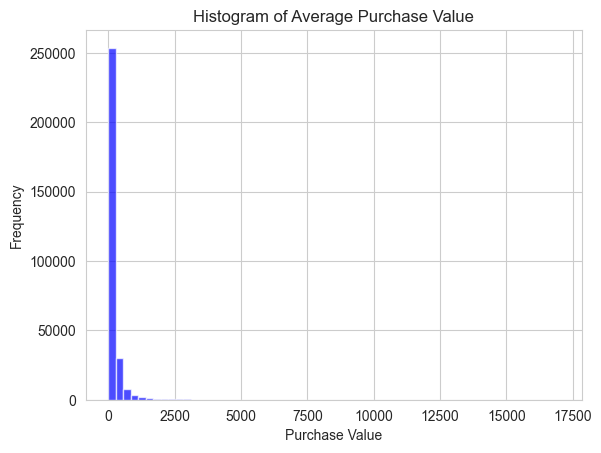

In [345]:
# hist plot para ver el valor promedio de compras 

plt.hist(data['amount'], bins=60, color='blue', alpha=0.7)
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.title('Histogram of Average Purchase Value')


In [346]:
# MODA de los valores en el conjunto de datos
mode_amount= data['amount'].mode()

print("de acuerdo al comportamiento de la distribucion cantidad por usuario se opta por tomar la moda:", mode_amount)


de acuerdo al comportamiento de la distribucion cantidad por usuario se opta por tomar la moda: 0    5.0
Name: amount, dtype: float64


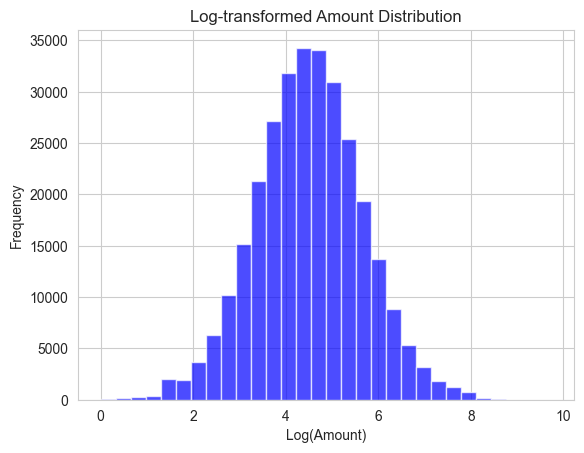

In [347]:
# log de amount

log_amount = np.log(data['amount'])
plt.hist(log_amount, bins=30, color='blue', alpha=0.7)
plt.title('Log-transformed Amount Distribution')
plt.xlabel('Log(Amount)')
plt.ylabel('Frequency')
plt.show()

### <a id='toc2_2_1_'></a>[Confirmacion de la moda en este caso](#toc0_)

## <a id='toc2_3_'></a>[Distribucion por Total de transacciones por usuario](#toc0_)


In [348]:
# AGRUPAMOS USER_ID POR TRANSACTION_ID

grouped_data = data.groupby('user_id')['transaction_id'].count()

print(grouped_data)

user_id
1       47
2       57
3       40
4       59
5       53
        ..
5996    41
5997    51
5998    49
5999    42
6000    45
Name: transaction_id, Length: 6000, dtype: int64


## <a id='toc2_4_'></a>[Distribucion del target (is_fraud)](#toc0_)


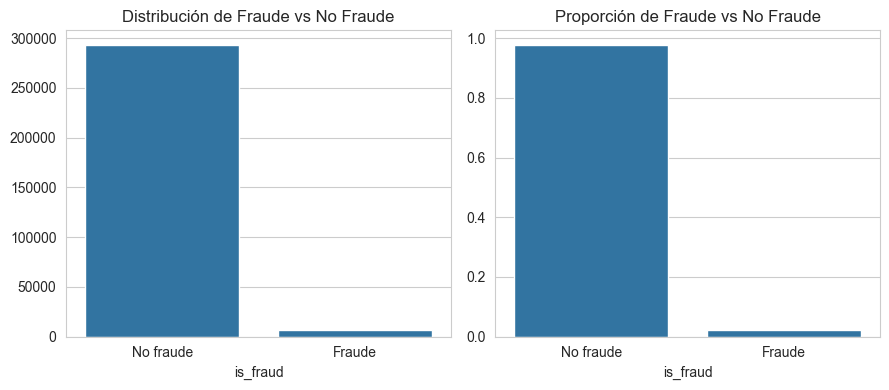

Fraud rate: 0.02206243013730626
is_fraud
0    293083
1      6612
Name: count, dtype: int64


In [349]:
# analisis de columna is_fraud

from locale import normalize


if 'is_fraud' in data.columns:
    
    counts= data['is_fraud'].value_counts().sort_index()
    props= data['is_fraud'].value_counts(normalize=True).sort_index()
    
    
    fig, ax = plt.subplots(1,2, figsize=(9,4))
    sns.barplot(x=counts.index.map({0:"No fraude", 1: "Fraude"}), y= counts.values, ax=ax[0])
    ax[0].set_title('Distribución de Fraude vs No Fraude')
    
    sns.barplot(x=props.index.map({0:"No fraude", 1: "Fraude"}), y=props.values, ax=ax[1])
    ax[1].set_title('Proporción de Fraude vs No Fraude')
    plt.tight_layout()
    plt.show()
    
    print("Fraud rate:", props.get (1, 0.0))
    

print(data['is_fraud'].value_counts())

### <a id='toc2_4_1_'></a>[Conclusiones preliminares del EDA](#toc0_)
Las variables monetarias presentan fuerte asimetría y cola larga: la mayoría de compras son pequeñas, pero existen valores muy altos. Estos outliers son reales y potencialmente informativos; no deben eliminarse, sino usarse como señal.
La transformación logarítmica de Amount estabiliza la escala y aproxima la distribución a una forma casi normal. Es conveniente incluir log_amount (y análogas) en el modelo para mejorar su estabilidad.
El problema está fuertemente desbalanceado: la clase fraude es muy minoritaria (del orden de pocos puntos porcentuales). Por ello:
Accuracy no es adecuada; se debe priorizar AUPRC/curva PR.
Es recomendable entrenar con class_weight='balanced' (o técnicas de muestreo) y seleccionar el umbral de decisión según costos de negocio.
Implicación operativa: al priorizar la captura de fraudes, habrá un trade-off con la tasa de alertas; el umbral deberá ajustarse a la capacidad de revisión.
Decisiones para modelado: conservar variables en crudo y en log, crear señales relativas al usuario (p. ej., amount_minus_user_avg, amount_over_user_avg) y añadir variables temporales simples (hora/día).

# <a id='toc3_'></a>[Diagrama de datos outliers](#toc0_)

In [350]:
# Identificacion de datos outliers 

num_cols= [c for c in ['amount','shipping_distance_km','account_age_days','total_transactions_user','avg_amount_user'] if c in data.columns]

num_cols  

['amount',
 'shipping_distance_km',
 'account_age_days',
 'total_transactions_user',
 'avg_amount_user']

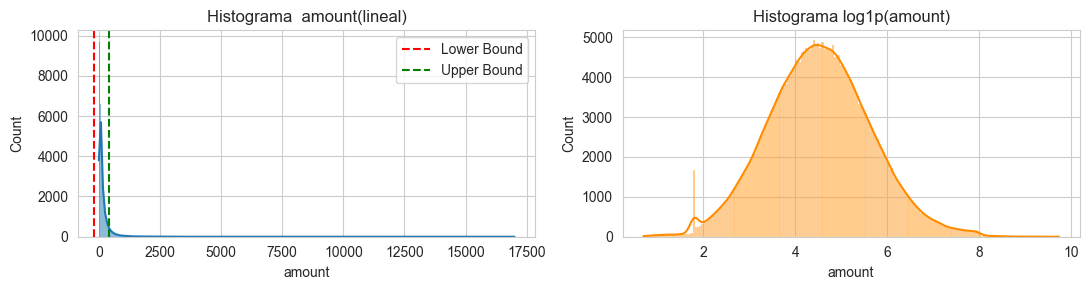

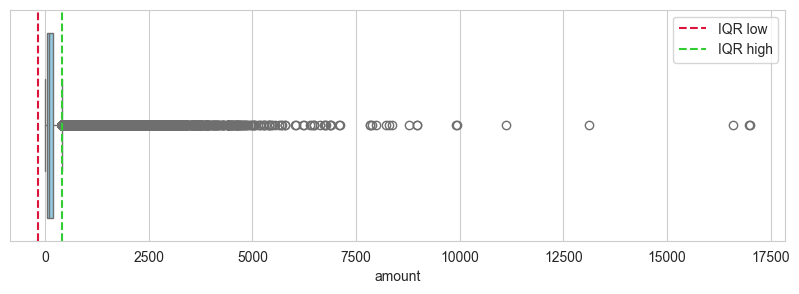

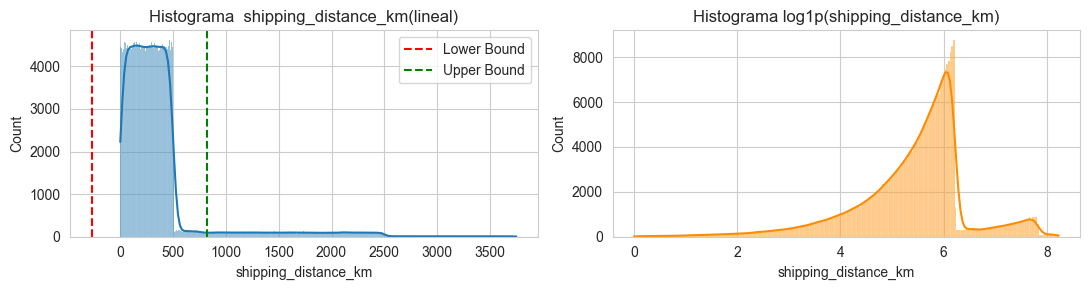

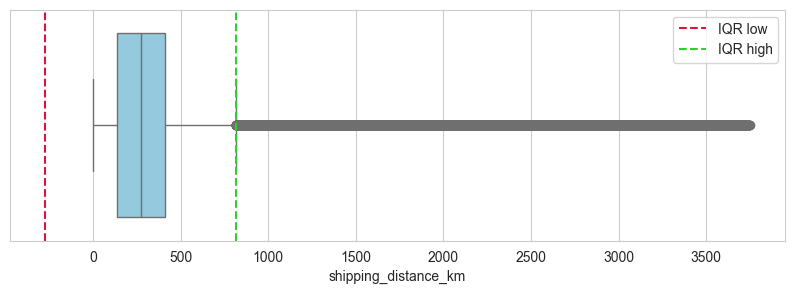

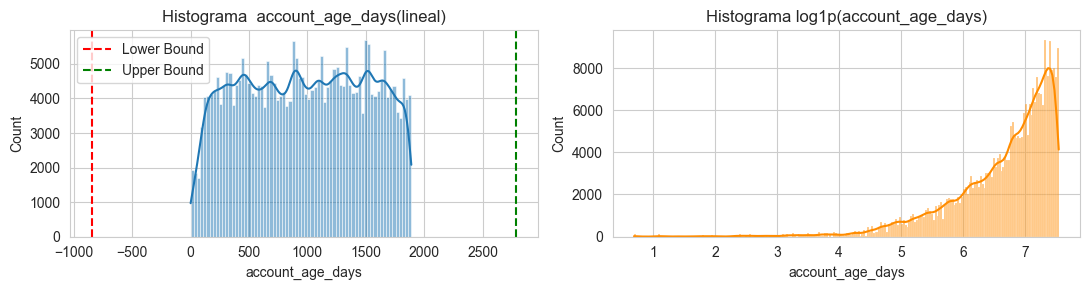

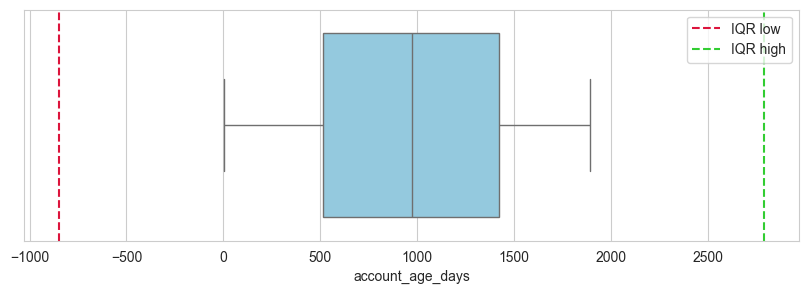

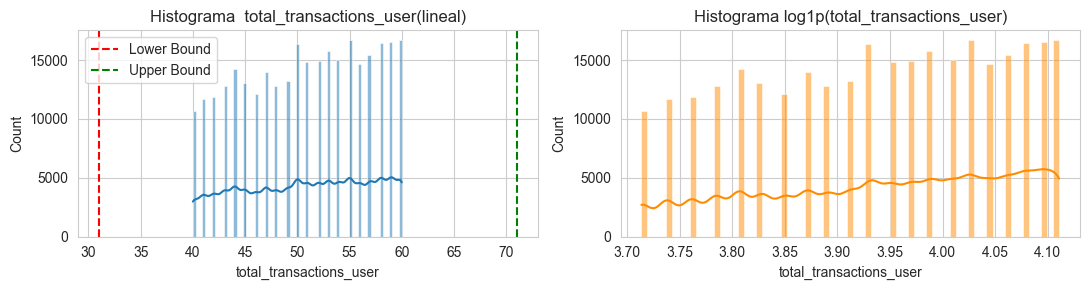

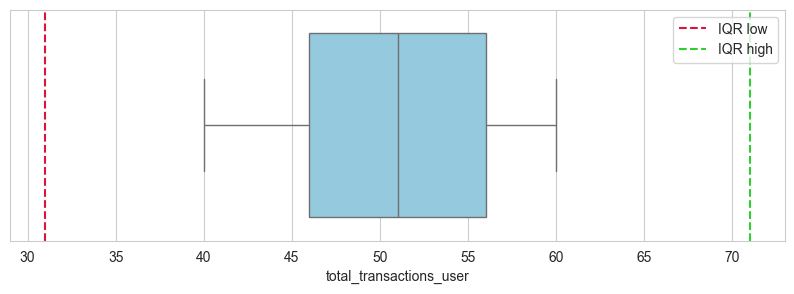

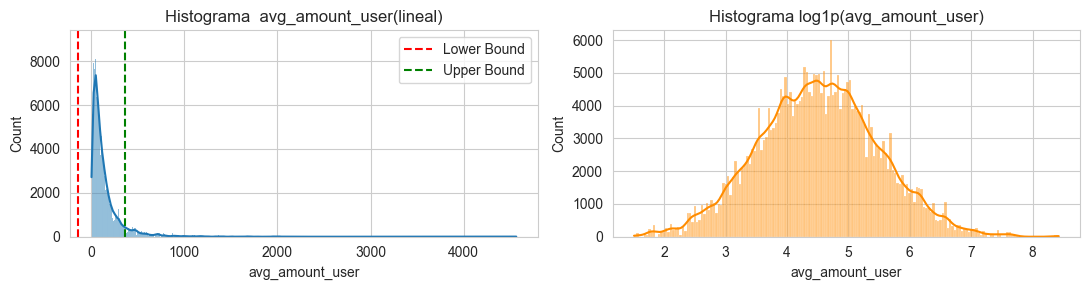

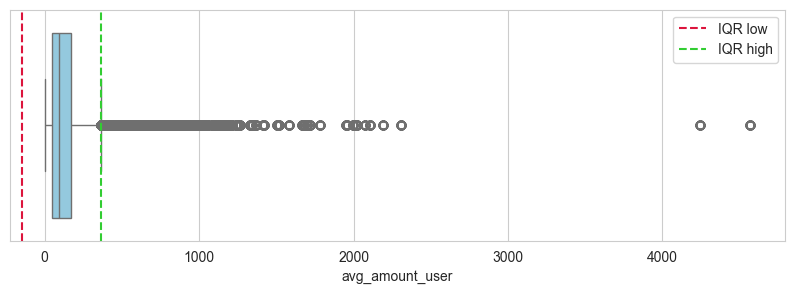

In [351]:
# Definimos funcion para determinar outliers usando IQR

from cProfile import label
from matplotlib.lines import lineStyles


def outliers_IQR (series):
    q1 = series.quantile(0.25)
    q3= series.quantile(0.75)
    iqr = q3 - q1 
    
    if iqr == 0:
        lo= series.quantile(0.01)
        hi= series.quantile(0.99)
    else:
        lo= q1 -1.5 * iqr
        hi= q3 +1.5* iqr
    return lo, hi,q1,q3

# Realizamos la segmentación de los datos para identificar outliers

summary=[]

for col in num_cols:
    series_all= data[col].astype(float) 
    
    lo,hi,q1,q3= outliers_IQR(series_all)
    out_low= int((series_all<lo).sum())
    out_high = int((series_all > hi).sum())
    summary.append((col, out_low, out_high, q1, q3))
         
    # Histogramas
    
    fig, ax= plt.subplots(1,2, figsize=(11,3))
    sns.histplot(series_all, bins='auto', kde=True, ax=ax[0])
    ax[0].axvline(x=lo, color='red', linestyle='--', label='Lower Bound')
    ax[0].axvline(x=hi, color='green', linestyle='--', label='Upper Bound')
    ax[0].set_title(f'Histograma  {col}(lineal)')
    ax[0].legend()
    
    vals_log = np.log1p(series_all.clip(lower=0))
    sns.histplot(vals_log, bins='auto', kde=True, ax=ax[1], color='darkorange')
    ax[1].set_title(f'Histograma log1p({col})')
    plt.tight_layout()
    plt.show()
    
    # Figura 2: boxplot
    plt.figure(figsize=(10,3))
    sns.boxplot(x=series_all, color='skyblue')
    plt.axvline(lo, color='crimson', linestyle='--', label='IQR low')
    plt.axvline(hi, color='limegreen', linestyle='--', label='IQR high')
    plt.legend()
    plt.show()

     

In [352]:
def iqr_flag(s):
    s = s.dropna().astype(float)
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo = q1 - 1.5*iqr
    hi = q3 + 1.5*iqr
    return (s < lo) | (s > hi), lo, hi

for col in ['amount','shipping_distance_km','avg_amount_user','account_age_days','total_transactions_user']:
    if col in data.columns and 'is_fraud' in data.columns:
        flag, lo, hi = iqr_flag(data[col])
        rate_out = data.loc[flag.fillna(False), 'is_fraud'].mean()
        rate_in  = data.loc[~flag.fillna(False), 'is_fraud'].mean()
        pct_out  = flag.mean()
        print(f"{col}: %outliers={pct_out:.2%} | fraud_rate_outliers={rate_out:.3%} | dentro={rate_in:.3%} | vallas [{lo:.2f},{hi:.2f}]")

amount: %outliers=8.91% | fraud_rate_outliers=7.401% | dentro=1.698% | vallas [-181.42,414.63]
shipping_distance_km: %outliers=6.78% | fraud_rate_outliers=12.810% | dentro=1.435% | vallas [-272.27,818.05]
avg_amount_user: %outliers=7.97% | fraud_rate_outliers=2.520% | dentro=2.179% | vallas [-144.70,364.34]
account_age_days: %outliers=0.00% | fraud_rate_outliers=nan% | dentro=2.206% | vallas [-847.50,2788.50]
total_transactions_user: %outliers=0.00% | fraud_rate_outliers=nan% | dentro=2.206% | vallas [31.00,71.00]


### <a id='toc3_1_1_'></a>[Conclusiones preliminares — Hallazgos y outliers](#toc0_)
amount
Distribución extremadamente asimétrica con cola larga; muchos valores altos aislados (grandes tickets).
La transformación log1p(amount) genera una forma casi normal — ideal para modelos lineales.
Los límites IQR marcan numerosos “outliers” a la derecha; no son errores, sino operaciones de alto valor.
Decisión: no eliminar ni capar agresivamente; usar log_amount y una bandera de “monto muy alto” definida con percentiles altos del train (p99–p99.5), mejor que con IQR.
shipping_distance_km
Fuerte cola derecha; existen envíos muy largos (miles de km).
log1p(shipping_distance_km) reduce la asimetría y estabiliza la escala.
Los “outliers” detectados por IQR a la derecha son informativos (suelen asociarse a mayor riesgo).
Decisión: conservar valores, usar log_shipping_distance_km y una bandera de “distancia muy alta”; considerar interacción con country_mismatch.
avg_amount_user
Cola larga con outliers en usuarios de ticket promedio alto.
Por sí misma aporta menos señal que el monto de la transacción, pero es útil comparar “transacción vs hábito del usuario”.
Decisión: priorizar features relativas: amount_minus_user_avg y amount_over_user_avg; la bandera de “promedio muy alto” es secundaria.
account_age_days
Sin outliers relevantes (los límites IQR negativos son artefactos de la fórmula).
Decisión: crear banderas de “cuenta nueva” (p.ej., <7, <30, <90 días). Suelen aumentar el poder predictivo.
total_transactions_user
Rango acotado y sin outliers relevantes.
Decisión: derivar tx_per_day = total_transactions_user / account_age_days para capturar intensidad de uso.
Sobre el uso de IQR vs percentiles
Con distribuciones tan asimétricas, el IQR tiende a etiquetar muchos puntos como outliers aunque sean comportamientos válidos.
Para modelado, es preferible definir “muy alto” con percentiles del conjunto de entrenamiento (p99–p99.5) y crear banderas, evitando leakage.
Implicaciones para el modelo
Conservar variables crudas y sus versiones log1p.
Añadir banderas de “muy alto” para amount y shipping_distance_km.
Incluir comparativas contra hábitos del usuario y señales temporales/geo (country_mismatch, hour, dow).
No eliminar outliers; son parte de la señal de fraude.

## <a id='toc3_2_'></a>[Grafico con hora de mayor flujo de transacciones](#toc0_)


    hour_minutes  transaction_id
0              0           12370
1              1           12723
2              2           12245
3              3           12545
4              4           12599
5              5           12479
6              6           12465
7              7           12267
8              8           12590
9              9           12373
10            10           12461
11            11           12542
12            12           12542
13            13           12396
14            14           12474
15            15           12466
16            16           12413
17            17           12628
18            18           12548
19            19           12330
20            20           12407
21            21           12799
22            22           12668
23            23           12365


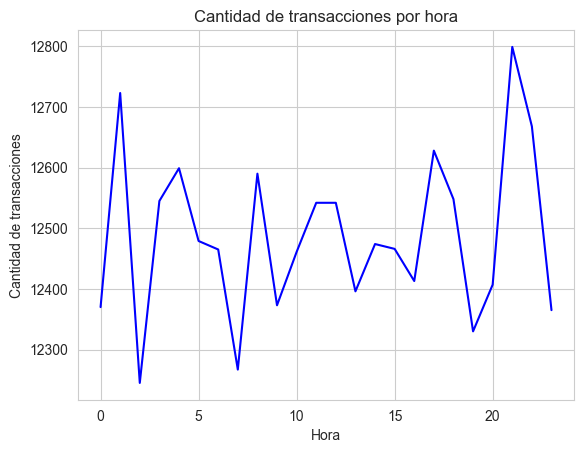

In [353]:
# hora con mayor numero de transacciones

data['hour_minutes']= data['transaction_time'].dt.hour
transaction_per_hour = data.groupby('hour_minutes')['transaction_id'].count().reset_index()

print(transaction_per_hour) 

# grafico de la cantidad de transacciones por hora
sns.lineplot(x='hour_minutes', y='transaction_id', data=transaction_per_hour, color='blue')
plt.title('Cantidad de transacciones por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de transacciones')
plt.show()

 

## <a id='toc3_3_'></a>[Matriz de correlacion de fraude](#toc0_)


shipping_distance_km       0.270004
avs_match                 -0.223299
cvv_result                -0.218982
amount                     0.202499
three_ds_flag             -0.162160
account_age_days          -0.120340
promo_used                 0.067351
total_transactions_user   -0.017093
transaction_id            -0.005295
user_id                   -0.005294
hour_minutes              -0.001911
avg_amount_user           -0.001236
dtype: float64


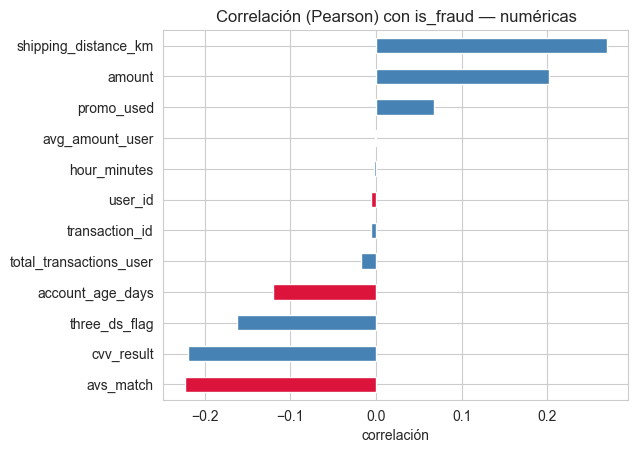

In [354]:
num_cols = data.select_dtypes(include='number').columns.drop('is_fraud', errors='ignore')

# Correlación Pearson con is_fraud y ordenamos por valor absoluto
corr_num = data[num_cols].corrwith(data['is_fraud']).sort_values(key=lambda s: s.abs(), ascending=False)

# Vista rápida (top 20)
print(corr_num.head(20))

# Gráfico simple (top 15)
top = corr_num.head(15)
colors = ['crimson' if v > 0 else 'steelblue' for v in top]
plt.figure(figsize=(6, 0.4*len(top)))
top.sort_values().plot(kind='barh', color=colors)
plt.title('Correlación (Pearson) con is_fraud — numéricas')
plt.xlabel('correlación')
plt.show()

### <a id='toc3_3_1_'></a>[Lecturas clave](#toc0_)

Más asociadas a fraude (positivas):
amount_minus_user_avg y amount_over_user_avg (~0.29): cuanto más se aleja el monto del hábito del usuario, mayor riesgo. Señal muy fuerte de anomalía individual.
shipping_distance_km (~0.23): envíos más lejanos aumentan el riesgo. Su versión logarítmica también es positiva, pero menor.
amount (~0.20): montos más altos se asocian a más fraude.
country_mismatch (~0.17–0.19): discrepancia entre país de la transacción y del BIN eleva riesgo.
promo_used (~0.07): usar promos/cupones tiene una asociación leve con fraude.
Factores protectores (negativas):
avs_match (−0.22), cvv_result (−0.20), three_ds_flag (~−0.12): cuando AVS/CVV/3DS “pasan”, el fraude cae; si fallan o no están, el riesgo sube.
account_age_days (~−0.10): cuentas más antiguas tienden a ser más confiables.
Prácticamente neutras:
user_id, transaction_id (~0): son identificadores, no aportan señal generalizable.
total_transactions_user (cerca de 0): leve efecto; mejor derivar intensidad (p. ej., transacciones/día).

# <a id='toc4_'></a>[MACHINE LEARNING MODEL IMPLEMENTATION](#toc0_)

## <a id='toc4_1_'></a>[CREACION DE FEATURES](#toc0_)

In [355]:
## Features por analizar

# Diferencia pais vs BIN (0: coincide: no coincide)
if{ 'country', 'bin_country'}. issubset(data.columns):
    data['country_mismatch']= (data['country'].astype(str) != data['bin_country'].astype(str)).astype(int)
    
# Creacion de hora y dia
if 'transaction_time' in data.columns:
    data['hour']= data['transaction_time'].dt.hour
    data['day']= data['transaction_time'].dt.day_name()

# Transformacion logaritmica para tratar las colas

if 'amount' in data.columns:
    data['log_amount']= np.log1p(data['amount'].clip(lower=0))
    
if 'shipping_distance_km' in data.columns:
    data['log_shipping_distance_km'] = np.log1p(data['shipping_distance_km'].clip(lower=0))

# Comparacion Monto Promedio 

if{'amount','avg_amount_user'}.issubset(data.columns):
    data['amount_minus_user_avg']= data['amount']-data['avg_amount_user']
    denom=np.where(data['avg_amount_user']>0, data['avg_amount_user'], np.nan)
    data['amount_over_user_avg'] = data['amount'] / denom
    
data.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud,hour_minutes,country_mismatch,hour,day,log_amount,log_shipping_distance_km,amount_minus_user_avg,amount_over_user_avg
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06 04:09:39+00:00,370.95,0,4,0,4,Saturday,4.451436,5.918759,-63.18,0.572906
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09 20:13:47+00:00,149.62,0,20,0,20,Tuesday,4.690430,5.014760,-40.03,0.729399
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12 06:20:11+00:00,164.08,0,6,0,6,Friday,4.536463,5.106430,-55.57,0.624349
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15 17:00:04+00:00,397.40,0,17,0,17,Monday,4.731538,5.987457,-35.46,0.760292
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17 01:27:31+00:00,935.28,0,1,1,1,Wednesday,4.897168,6.841915,-15.02,0.898465


In [356]:
# Entrenamiento del modelo de detección de fraude 

from sklearn.model_selection import train_test_split

num_features= [c for c in ['log_amount','log_shipping_distance_km',
    'amount_minus_user_avg','amount_over_user_avg',
    'account_age_days','total_transactions_user',
    'avg_amount_user','shipping_distance_km','amount',
    'country_mismatch','hour'] if c in data.columns]

cat_features =[c for c in ['channel', 'merchant_category', 'country', 'bin_country', 'day'] if c in data.columns]

X= data[num_features + cat_features].copy()
y= data['is_fraud'].astype(int)

# Split simple y estratificado (mantiene proporción de fraude en ambos sets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((239756, 16),
 (59939, 16),
 np.float64(0.02206409850014181),
 np.float64(0.022055756685964063))

In [357]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Preprocesamiento:
# - Numéricas: imputa medianas y escala (Regresión Logística rinde mejor con escalado)
# - Categóricas: one-hot y ignora categorías nuevas si aparecen

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_features), ('cat', categorical_transformer, cat_features),],
    remainder='drop'
)


# Modelo regresión logística para detección de fraude

model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Entrenamos

clf = Pipeline(steps=[('prep',preprocess),('model', model),])

clf.fit(X_train, y_train)

# Probabilidades de fraude en el test (emtre 0 y 1)
y_proba= clf.predict_proba(X_test)[:,1] 

print("Entrenado. Ejemplo de probabilidades:", y_proba)

Entrenado. Ejemplo de probabilidades: [0.07539683 0.02350343 0.26383567 ... 0.21016782 0.04016342 0.24083204]


## <a id='toc4_2_'></a>[Metricas Clave: AUPRC y ROC-AUC](#toc0_)

AUPRC: 0.5146, ROC AUC: 0.9035


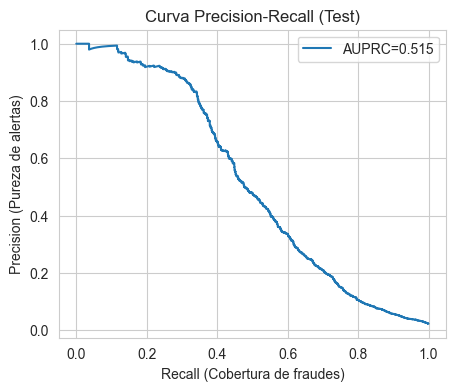

In [358]:
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt


auprc= average_precision_score(y_test,y_proba)

roc= roc_auc_score(y_test, y_proba)

print(f"AUPRC: {auprc:.4f}, ROC AUC: {roc:.4f}")

# Curva Precision-Recall (la más útil con desbalance)
prec, rec, thr = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AUPRC={auprc:.3f}")
plt.xlabel("Recall (Cobertura de fraudes)")
plt.ylabel("Precision (Pureza de alertas)")
plt.title("Curva Precision-Recall (Test)")
plt.legend()
plt.show()

### <a id='toc4_2_1_'></a>[Conclusión clave](#toc0_)
El modelo ordena muy bien el riesgo: con AUPRC=0.515 frente a una prevalencia de ~2%, es ~20–25× mejor que el azar. Esto permite elegir umbrales según el costo: podemos lograr alta cobertura de fraude moviéndonos a la derecha de la curva, asumiendo menor precisión, o subir el umbral para mayor pureza de alertas con menor recall.

In [359]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix 

C_FN, C_FP = 50, 1  # puedes cambiarlos según tu negocio

# Probamos varios umbrales (200 valores a lo largo de todas las probabilidades)
thr_grid = np.unique(np.quantile(y_proba, np.linspace(0, 1, 201)))

def cost_and_pred(t):
    y_pred = (y_proba >= t).astype(int)
    FP = int(((y_test==0) & (y_pred==1)).sum())
    FN = int(((y_test==1) & (y_pred==0)).sum())
    cost = C_FP*FP + C_FN*FN
    return cost, y_pred, FP, FN

costs = [cost_and_pred(t)[0] for t in thr_grid]
best_t = float(thr_grid[int(np.argmin(costs))]) 
print("Mejor umbral para la deteccion de fraudes", best_t)

best_cost, y_pred_opt, FP, FN = cost_and_pred(best_t)
TP = int(((y_test==1) & (y_pred_opt==1)).sum())
TN = int(((y_test==0) & (y_pred_opt==0)).sum())

print(f"Umbral óptimo t*={best_t:.4f} | Costo={best_cost}")
print(f"TP={TP} | FP={FP} | FN={FN} | TN={TN}")
print(f"Precision={precision_score(y_test,y_pred_opt):.3f} | Recall={recall_score(y_test,y_pred_opt):.3f} | F1={f1_score(y_test,y_pred_opt):.3f}")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_opt))
print(f"Tasa de alertas: {y_pred_opt.mean():.2%}")

Mejor umbral para la deteccion de fraudes 0.48503097343748014
Umbral óptimo t*=0.4850 | Costo=21841
TP=1050 | FP=8241 | FN=272 | TN=50376
Precision=0.113 | Recall=0.794 | F1=0.198
Matriz de confusión:
 [[50376  8241]
 [  272  1050]]
Tasa de alertas: 15.50%


### <a id='toc4_2_2_'></a>[Conclusion Clave](#toc0_)
Bajo la matriz de costos definida (C_FN=50, C_FP=1), el umbral de 0.485 es la regla de decisión que minimiza el costo total en test. Con este punto operamos con una tasa de alertas del 15.5%, capturamos 1,050 de 1,322 fraudes (recall 79.4%) y aceptamos una precisión del 11.3% (aprox. 1 de cada 9 alertas es fraude real). El costo resultante (21,841) es sustancialmente inferior a las estrategias triviales: reduciría en torno a 67% el costo de “no alertar nada” y en ~63% el de “alertarlo todo”.

En términos operativos, el modelo prioriza cobertura de fraude —coherente con penalizar fuerte los FN— a cambio de un volumen moderado de revisiones humanas. Si la capacidad de revisión es menor, se puede subir ligeramente el umbral para disminuir la tasa de alertas a costa de algo de recall; si el objetivo es maximizar la captura, se puede bajar. Como conclusión práctica, 0.485 es un punto de equilibrio costo–operación adecuado para adoptar como umbral inicial, sujeto a monitoreo y recalibración periódica según capacidad y drift.

In [360]:
# grafico de la cantidad de casos de posible fraude despues de entrenar el modelo Vs anteriores



# 1) X e y del dataset completo (reutilizando tus listas de columnas)
X_all = data[[c for c in (num_features + cat_features) if c in data.columns]].copy()
y_all = data['is_fraud'].astype(int)

# 2) Umbral: reutiliza el que ya calculaste (ajústalo si tu valor fue distinto)
try:
    best_t = 0.8
except NameError:
    best_t

# 3) Probabilidades y predicción binaria en TODO el dataset
y_proba_all = clf.predict_proba(X_all)[:, 1]
y_pred_all  = (y_proba_all >= best_t).astype(int)

# 4) Conteos (TP, FP, FN, TN) y métricas rápidas
TP_all = int(((y_all==1) & (y_pred_all==1)).sum())
FP_all = int(((y_all==0) & (y_pred_all==1)).sum())
FN_all = int(((y_all==1) & (y_pred_all==0)).sum())
TN_all = int(((y_all==0) & (y_pred_all==0)).sum())

fraudes_reales_all   = int(y_all.sum())
posibles_fraudes_all = int(y_pred_all.sum())

precision_all = TP_all / (TP_all + FP_all) if (TP_all + FP_all) > 0 else 0.0
recall_all    = TP_all / (TP_all + FN_all) if (TP_all + FN_all) > 0 else 0.0

print(f"Fraudes reales (todo): {fraudes_reales_all:,}")
print(f"Posibles fraudes (modelo, todo): {posibles_fraudes_all:,}")
print(f"TP={TP_all} | FP={FP_all} | FN={FN_all} | TN={TN_all}")
print(f"Precisión={precision_all:.3f} | Recall={recall_all:.3f}")

Fraudes reales (todo): 6,612
Posibles fraudes (modelo, todo): 10,853
TP=3826 | FP=7027 | FN=2786 | TN=286056
Precisión=0.353 | Recall=0.579


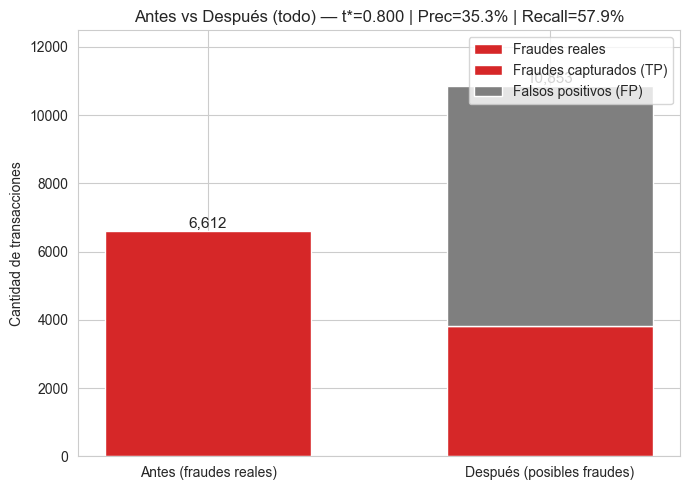

In [361]:

labels = ['Antes (fraudes reales)', 'Después (posibles fraudes)']
x = np.arange(len(labels))
width = 0.6

plt.figure(figsize=(7,5))

# Barra "Antes": solo fraudes reales
plt.bar(x[0], fraudes_reales_all, width, color='#d62728', label='Fraudes reales')

# Barra "Después": apilada TP (rojo) + FP (gris)
plt.bar(x[1], TP_all, width, color='#d62728', label='Fraudes capturados (TP)')
plt.bar(x[1], FP_all, width, bottom=TP_all, color='#7f7f7f', label='Falsos positivos (FP)')

# Etiquetas numéricas
plt.text(x[0], fraudes_reales_all, f'{fraudes_reales_all:,}', ha='center', va='bottom', fontsize=11)
plt.text(x[1], posibles_fraudes_all, f'{posibles_fraudes_all:,}', ha='center', va='bottom', fontsize=11)

plt.xticks(x, labels)
plt.ylabel('Cantidad de transacciones')
plt.title(f'Antes vs Después (todo) — t*={best_t:.3f} | Prec={precision_all:.1%} | Recall={recall_all:.1%}')
plt.legend(loc='upper right')
plt.ylim(0, max(fraudes_reales_all, posibles_fraudes_all)*1.15)
plt.tight_layout()
plt.show()

# <a id='toc5_'></a>[Conclusión final del proyecto](#toc0_)

``Panorama general``
Dataset de ~299,695 transacciones con prevalencia de fraude ≈ 2.2%.
EDA mostró variables con colas largas (amount, shipping_distance_km) y outliers informativos; los aprovechamos con transformaciones log y banderas. La comparación del monto con el hábito del usuario resultó especialmente útil.
En test, el modelo presenta buena capacidad de ranking: AUPRC=0.515 (muy por encima del baseline ≈2.2%). Los principales impulsores de riesgo fueron: desviación del monto vs. promedio del usuario, distancia de envío y country_mismatch; señales de AVS/CVV/3DS actúan como protectoras.

---
``Decisión de umbral y desempeño operativo (evaluado sobre todo el dataset)``
Con el umbral t=0.800 (escogido para limitar carga operativa), el modelo marca 10,853 posibles fraudes (tasa de alertas ≈ 3.6%).
Efectividad de las alertas: Precisión=35.3% (≈ 1 de cada 3 alertas es fraude real) y Recall=57.9% (captura 3,826 de los 6,612 fraudes), con 7,027 falsos positivos y 2,786 fraudes que se escapan.
Lift operativo: a igual tasa de revisión (3.6%), pasar de revisar al azar a revisar lo que prioriza el modelo multiplica por ~16 la probabilidad de encontrar fraude (0.353/0.022 ≈ 16).
Con la función de costo de referencia (C_FN=50, C_FP=1), este punto implicaría un costo agregado de ~146,327 frente a ~330,600 si no se alertara nada y ~293,083 si se alertara todo, es decir, un ahorro aproximado del 56% y 50% respectivamente. Nota: estos cálculos a nivel “todo el dataset” son ilustrativos para planificación operativa.

---
``Trade‑off y punto de partida recomendado``
Para minimizar costo puro en test, el umbral óptimo fue t≈0.485, con mayor recall y una tasa de alertas ≈15.5%.
Para limitar el volumen de revisiones, t=0.800 ofrece un equilibrio práctico: 3.6% de alertas con una precisión 16× superior a la prevalencia y una cobertura de fraude cercana al 58%.
En producción, se recomienda fijar explícitamente un objetivo operativo (p. ej., “≤4% de alertas diarias”) y derivar el umbral a partir de ese objetivo usando los percentiles de las probabilidades.

---
``Limitaciones y consideraciones``
Las métricas en “todo el dataset” incluyen filas de entrenamiento; deben usarse para dimensionar operación, no para reportar performance fuera de muestra. Para performance generalizable, referirse a los resultados de test (AUPRC, costo y matriz de confusión).
Posible drift de datos y cambios en patrones de fraude exigen monitoreo y recalibración periódica del umbral y, si fuera necesario, re‑entrenamiento.

---
`Recomendaciones inmediatas`
Producción: desplegar el pipeline con logging de probabilidades, decisiones y resultados; monitorear AUPRC, tasa de alertas, precision@k y costo diario.
Calibración y modelos: evaluar calibración de probabilidades (Platt/isotónica) y probar un modelo de árboles (HistGradientBoosting/LightGBM) con las mismas features para intentar elevar AUPRC y bajar costo a igual tasa de alertas.
Segmentación operativa: considerar umbrales diferenciados por país/canal/hora para optimizar el trade‑off según la capacidad de revisión de cada segmento.